Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "តapiwanashe Nkompilo"
COLLABORATORS = "Victor Azih" " Keagan Larson" 

---

DS320 Spring 2023: Final Project

Posted on Wed 05/03/ 23, Due on Mon 05/15/23 at 11:59 PM

We continue with the HCQ dataset in the midterm, and you are provided few more datasets: the Google Trend score of HCQ searching in 2020, tweets with sentiments, and geoMap.

You will use the clean HCQ dataset you have done for the midterm project. Do not upload the dataset to your Jupyter Luther since it is big. You need to download this notebook and work on it with Google Colab.

There are 10 tasks, each is worth 10 points. The bonus task is worth 20 points.

Note: I will mannually grade your code, so no test cases will be provided, but I can give you the expectation of the outcomes for tasks as I can.


# Import libraries

In [1]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#auxiliary libraries
import numpy as np
import geopandas as gpd

In [3]:
df_tweets  = pd.read_csv('clean_tweet_state.csv')
df_geomap = pd.read_csv('geoMap.csv')
df_ggtrend = pd.read_csv('gg_trend_2020.csv')
df_event = pd.read_csv('HCQ_event.csv')

## Task 1: 

We want to see the online users’ reaction patterns in the time
domain, including (a) Number of tweets, favorites on Twitter, (b) Google
keyword search score.

Create the following plot. You can take the events of the plot from the HCQ_event.csv file. Your figure should look similar (though not necessarily identical)

![Task 1](./images/task1.png)

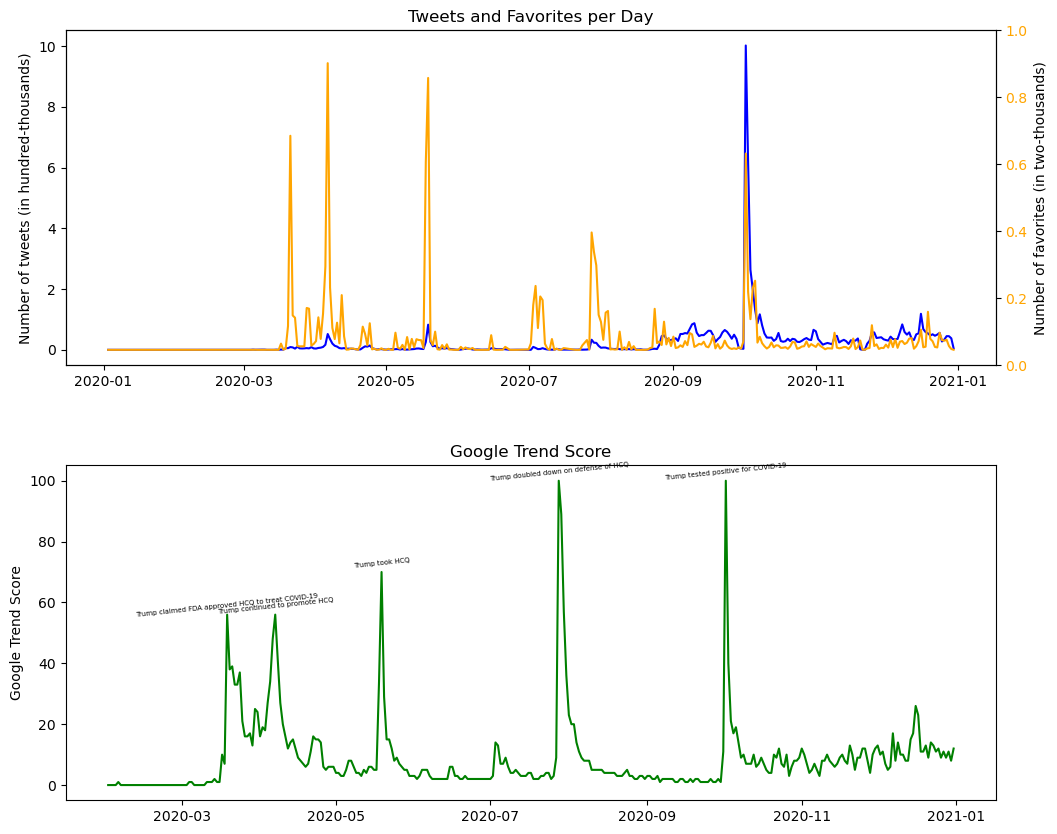

In [4]:
df_ggtrend['date'] = pd.to_datetime(df_ggtrend['Day'])
df_ggtrend.drop(['Day'], axis=1, inplace=True)
df_tweets['date'] = pd.to_datetime(df_tweets['created_at'])
df_tweets.drop(['created_at'], axis=1, inplace=True)
df_event['date'] = pd.to_datetime(df_event['date'])

df_tweets_counts = df_tweets.groupby('date')['full_text'].count().div(2000)
df_tweets_favorites = df_tweets.groupby('date')['favorite_count'].sum().div(100000)
df_tweets_combined = pd.concat([df_tweets_counts, df_tweets_favorites], axis=1)

df_trend_scores = df_ggtrend.groupby('date')['score'].sum()

fig, axs = plt.subplots(nrows=2, figsize=(12,10))

axs[0].plot(df_tweets_combined.index, df_tweets_combined['full_text'], color='blue')
axs[0].plot(df_tweets_combined.index, df_tweets_combined['favorite_count'], color='orange')
axs[0].set_title('Tweets and Favorites per Day')
axs[0].set_ylabel('Number of tweets (in hundred-thousands)')

ax2 = axs[0].twinx()
ax2.set_ylabel('Number of favorites (in two-thousands)')
ax2.tick_params(axis='y', labelcolor='orange')

axs[1].plot(df_trend_scores.index, df_trend_scores.values, color='green')
axs[1].set_title('Google Trend Score')
axs[1].set_ylabel('Google Trend Score')

for i, row in df_event.iterrows():
    date = row['date']
    event = row['event']
    if date in df_trend_scores.index:
        score = df_trend_scores[date]
        axs[1].annotate(event, xy=(date, score), xytext=(date, score+3), ha='center', fontsize=5, va='center', rotation=6)

plt.subplots_adjust(hspace=0.3)
plt.xticks(rotation=45)

plt.show()

## Task 2: 

We want to look closer at the number of tweets and favorites sent out on the five above days (the days you made annotations on) 

Create the following plot. Your figure should look similar (though not necessarily identical)

In this plot, 

<b>
the teal bars = #tweets on an event day / mean of #tweets on a 
day

the salmon bars = #favorites on an event day / mean of #favorites on a 
day
</b>
![Task 2](./images/task2.png)

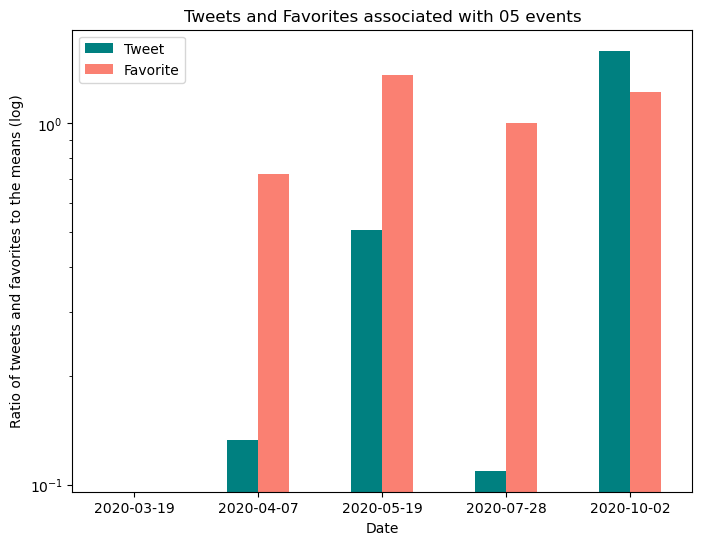

In [5]:
event_dates = ['2020-03-19', '2020-04-07', '2020-05-19', '2020-07-28', '2020-10-02']

df_event_dates = pd.DataFrame({'date': event_dates})
df_event_dates['date'] = pd.to_datetime(df_event_dates['date'], format='%Y-%m-%d')
df_tweets_events = df_tweets_combined.merge(df_event_dates, on='date')
df_tweets_events.set_index('date', inplace=True)

mean_tweets = df_tweets_combined['full_text'].mean()
mean_favorites = df_tweets_combined['favorite_count'].mean()

df_tweets_events_ratio = df_tweets_events.div([mean_tweets, mean_favorites], axis=1)
df_tweets_events_ratio_log = np.log10(df_tweets_events_ratio)


ax = df_tweets_events_ratio_log.plot(kind='bar', figsize=(8, 6), color=['teal', 'salmon'], log=True)
ax.set_title('Tweets and Favorites associated with 05 events')
ax.set_ylabel('Ratio of tweets and favorites to the means (log)')
ax.set_xlabel('Date')
ax.legend(labels=['Tweet', 'Favorite'])
ax.set_xticklabels(df_tweets_events_ratio_log.index.date, rotation=0)
plt.show()

## Task 3: 

We want to see the distributions of reply_count and retweet_count for a tweet.

Create the following plot. Your figure should look similar (though not necessarily identical)

<i><b>What insights do you recognize from the plot?</b></i>

![Task 3](./images/task3.png)

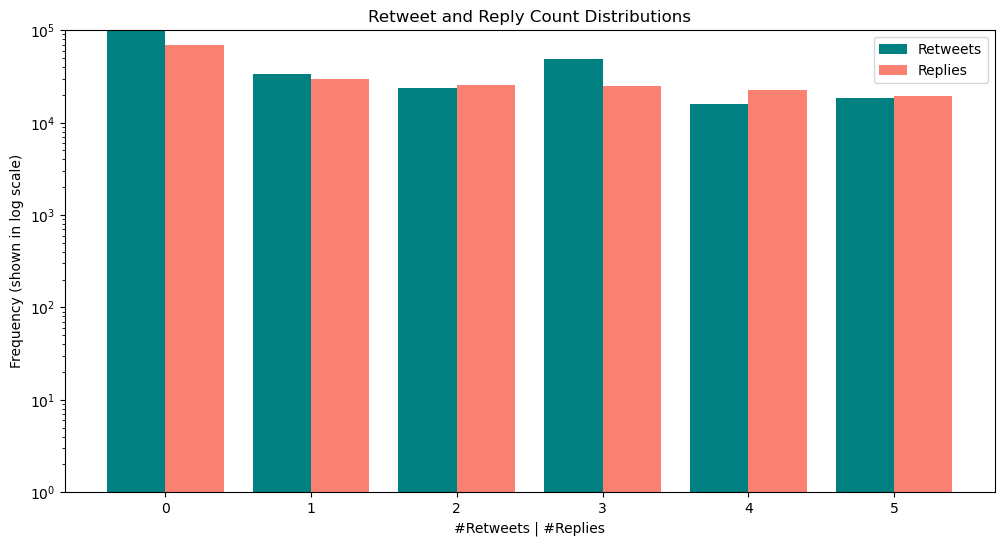

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

df_grouped = df_tweets.groupby('full_text', as_index=False).agg({'reply_count': 'sum', 'retweet_count': 'sum'})

df_grouped = df_grouped.sort_values(by='reply_count', ascending=False)

df_grouped = df_grouped.iloc[:6, :]

df_grouped['total_count'] = df_grouped['reply_count'] + df_grouped['retweet_count']

bar_width = 0.4
x_pos = np.arange(len(df_grouped))
ax.bar(x_pos, df_grouped['retweet_count'], width=bar_width, color='teal', log=True, label='Retweets')
ax.bar(x_pos + bar_width, df_grouped['reply_count'], width=bar_width, color='salmon', log=True, label='Replies')

ax.set_title('Retweet and Reply Count Distributions')
ax.set_xlabel('#Retweets | #Replies')
ax.set_ylabel('Frequency (shown in log scale)')
ax.set_xticks(x_pos + bar_width / 2)
ax.set_xticklabels(np.arange(len(df_grouped)))
ax.set_ylim([1, 10**5])
ax.legend()

plt.show()

## Task 4: 

We want to look see if there is any patterns of posted tweets and favorites over days of weeks.

Create the following plot. Your figure should look similar (though not necessarily identical)

<i><b>What insights do you recognize from the plot?</b></i>

![Task 4](./images/task4.png)

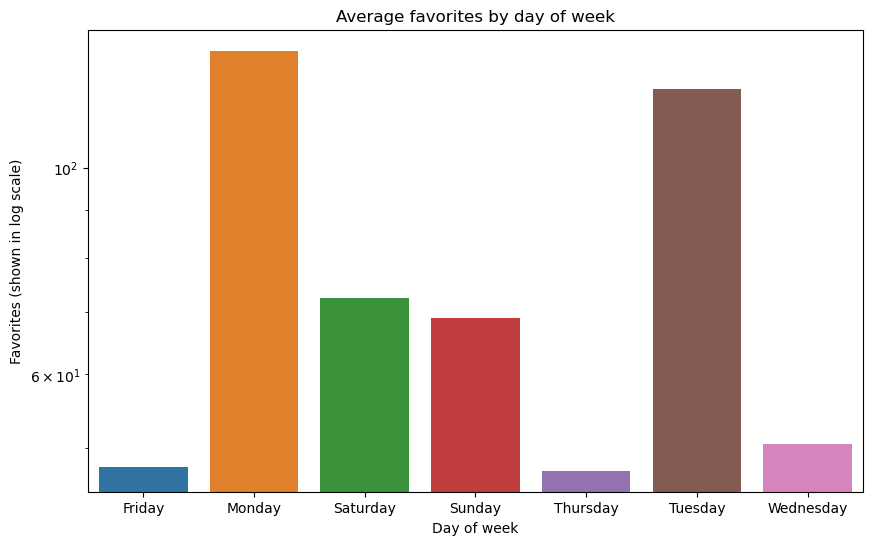

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

df_tweets['day_of_week'] = df_tweets['date'].dt.day_name()

df_avg_favorites = df_tweets.groupby('day_of_week', as_index=False)['favorite_count'].mean()

sns.barplot(x='day_of_week', y='favorite_count', data=df_avg_favorites, ax=ax)

ax.set_title('Average favorites by day of week')
ax.set_xlabel('Day of week')
ax.set_ylabel('Favorites (shown in log scale)')
ax.set_yscale('log')

plt.show()

## Task 5: 

We want to look see if there is any relationships between the number of tweets and the number of favorites sending out on a day.

Create the following plot. Your figure should look similar (though not necessarily identical)

<i><b>What insights do you recognize from the plot?</b></i>

![Task 5](./images/task5.png)

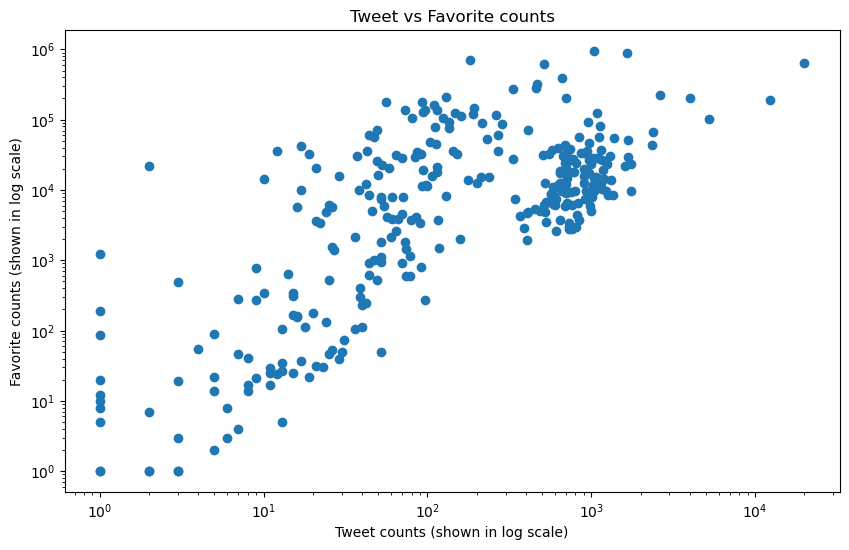

In [9]:
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

df_grouped = df_tweets.groupby('date', as_index=False).agg({'full_text': 'count', 'favorite_count': 'sum'})

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_grouped['full_text'], df_grouped['favorite_count'])
ax.set_xlabel('Tweet counts (shown in log scale)')
ax.set_ylabel('Favorite counts (shown in log scale)')
ax.set_title('Tweet vs Favorite counts')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

## Task 6: 

Use the geoMap.csv file to produce a heatmap of Google HCQ searching score over states in the US.  

Create the following plot. Your figure should look similar (though not necessarily identical)

![Task 6](./images/task6.png)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/ds320/share/proj failed
/tmp/ipykernel_2910019/2565890879.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


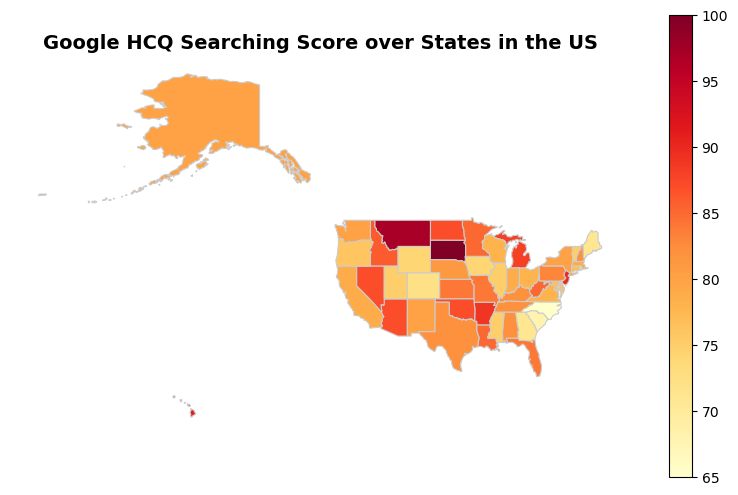

In [10]:
us_states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')
merged_data = pd.merge(us_states, df_geomap, left_on='name', right_on='State')

fig, ax = plt.subplots(figsize=(10,6))

merged_data.plot(column='Score', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

ax.axis('off')

ax.set_title('Google HCQ Searching Score over States in the US', fontdict={'fontsize': '14', 'fontweight' : 'bold'})

vmin, vmax = df_geomap['Score'].min(), df_geomap['Score'].max()
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

plt.show()

## Task 7: 

Use the tweets_manual_classifying.csv file to produce wordcloud plots

(a) Most frequently used words, 

(b) [Bonus: 20 points for this plot] Positive vs. negative words using ”Bing” lexicon

Create the following plot. 

Your figure should look similar (though not necessarily identical)

![Task 7](./images/task7.png)

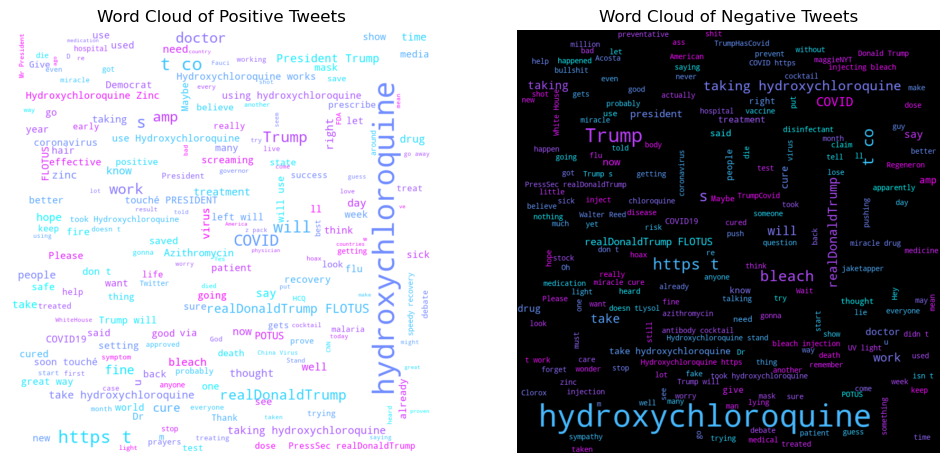

In [25]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

final=pd.read_csv("tweets_manual_classifying.csv")
# Combine positive and negative tweets into separate strings
positive_tweets = ' '.join(final[final['manual_positivity'] == 'pos']['full_text'].astype(str))
negative_tweets = ' '.join(final[final['manual_positivity'] == 'neg']['full_text'].astype(str))

# Create the WordCloud objects for positive and negative tweets
positive_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='cool') .generate(positive_tweets)
negative_wordcloud = WordCloud(width=800, height=800, background_color='black', colormap='cool').generate(negative_tweets)

# Plot the word clouds
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Positive Tweets')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud of Negative Tweets')

plt.show()
                               
                               














In [16]:
tweets

NameError: name 'tweets' is not defined

## Task 8, 9, and 10

Imagine that you are trying to gain insights from the HCQ dataset. You have done 7 plots. Take a moment to review what you get from those plots: patterns, trends, relationships, ...

Now you will explore things yourself. Create 03 plots for task 8, 9, and 10. For each plot, justify why you want to create it. You may not see any patterns but it is worth it as you know no patterns there.

You can use some hints I put here but you do not have to. I would love to see your exploration.

Hints:

#1 Think about the State column you created in the midterm project. We have not used it.

#2 We have not used a period of a month


## Task 8
We want to look see if there is any patterns of posted tweets and favorites over months.

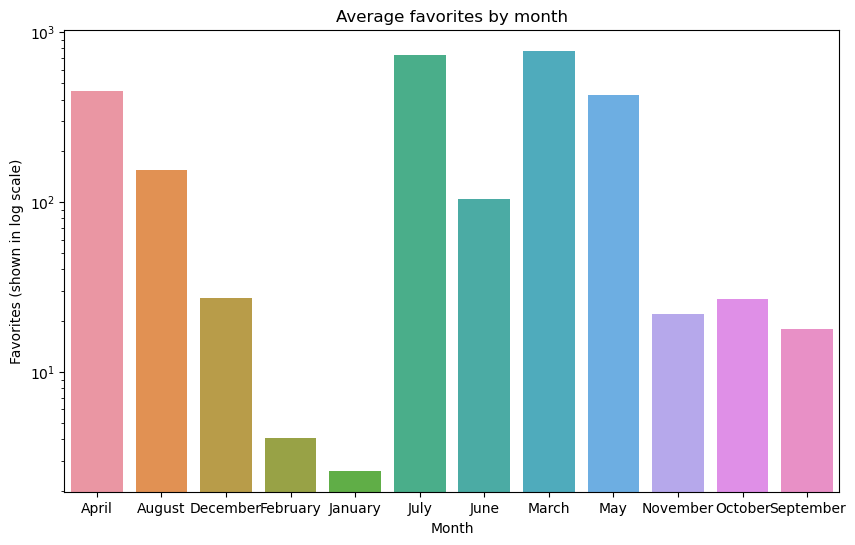

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

df_tweets['month'] = df_tweets['date'].dt.month_name()

df_avg_favorites = df_tweets.groupby('month', as_index=False)['favorite_count'].mean()

sns.barplot(x='month', y='favorite_count', data=df_avg_favorites, ax=ax)

ax.set_title('Average favorites by month')
ax.set_xlabel('Month')
ax.set_ylabel('Favorites (shown in log scale)')
ax.set_yscale('log')

plt.show()

## Task 9
We want to look see if there is any patterns of posted tweets and retweet count over months.

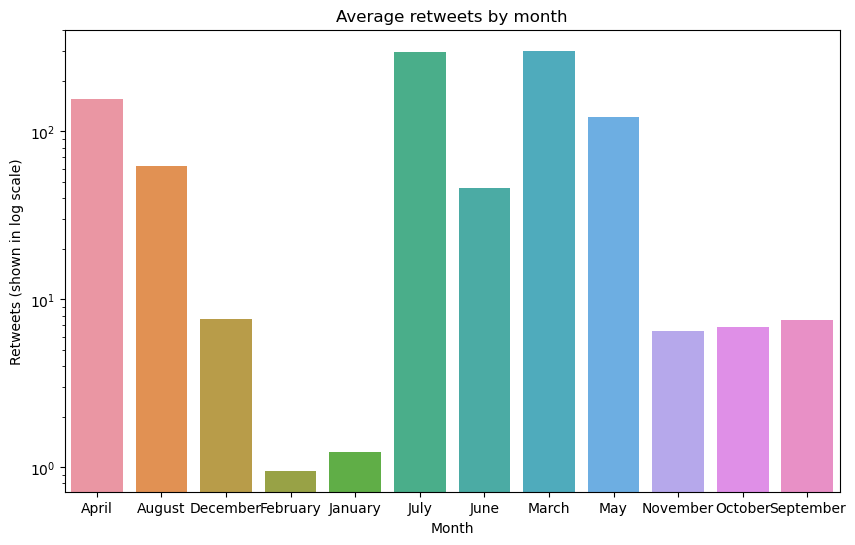

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

df_tweets['month'] = df_tweets['date'].dt.month_name()

df_avg_favorites = df_tweets.groupby('month', as_index=False)['retweet_count'].mean()

sns.barplot(x='month', y='retweet_count', data=df_avg_favorites, ax=ax)

ax.set_title('Average retweets by month')
ax.set_xlabel('Month')
ax.set_ylabel('Retweets (shown in log scale)')
ax.set_yscale('log')

plt.show()

AttributeError: 'DataFrame' object has no attribute 'manual_positivity'

## Notice that this distribution is very similar to the one before it
## This suggests that the average favorite and average retweet are heavily correlated


## Task 10: 

We want to look see if there is any relationships between the number of tweets and the number of retweets sending out on a day.

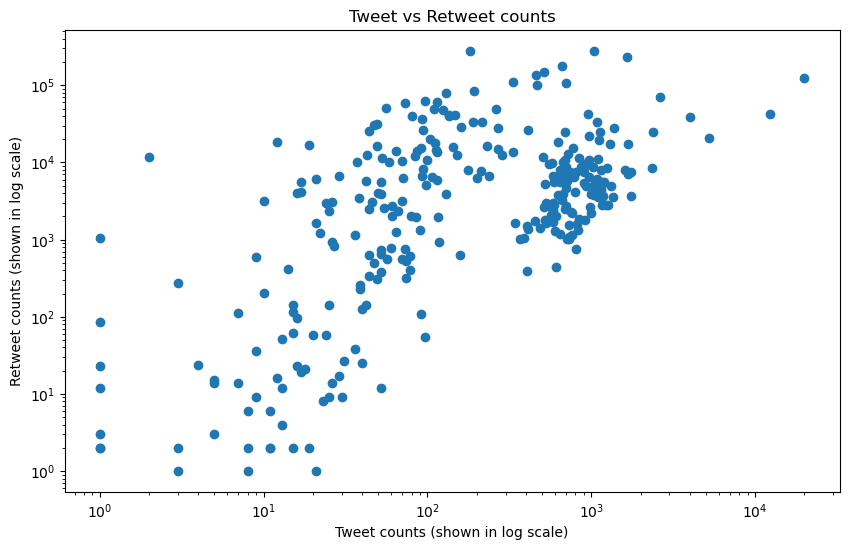

In [14]:
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

df_grouped = df_tweets.groupby('date', as_index=False).agg({'full_text': 'count', 'retweet_count': 'sum'})

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_grouped['full_text'], df_grouped['retweet_count'])
ax.set_xlabel('Tweet counts (shown in log scale)')
ax.set_ylabel('Retweet counts (shown in log scale)')
ax.set_title('Tweet vs Retweet counts')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

## Again, notice how similar this scatter plot is to the one in Task 5
## This suggests a heavy correlation between retweets and favorites